In [1]:
!nvidia-smi

Thu Oct 31 14:07:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  |   00000000:01:00.0 Off |                  N/A |
| 40%   33C    P8             13W /  230W |       0MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from numba import njit
import time
@njit


def Slow_Count(A, B):
    MatA_rows = A.shape[0]
    MatA_colls = A.shape[1]
    MatBColls = B.shape[1]
    
    # Просто по правилу умножения задач размер результирующей матрицы
    C = np.zeros((MatA_rows, MatBColls))
    
    for i in range(MatA_rows):
        for j in range(MatBColls):
            for k in range(MatA_colls):
                C[i, j] += A[i, k] * B[k, j]
    return C

In [ ]:
def Timer_1(A, B):
    start_time = time.time()
    # Вызов фцнкции для начала подсчета на CPU
    C = Slow_Count(A, B)
    # Отсекаю время
    end_time = time.time()
    
    time_delta=abs(start_time-end_time)
    
    return C, time_delta

In [6]:
from numba import cuda

# Ядро

# Компилирование моей функции на GPU
@cuda.jit
def Fast_Count(A, B, C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

def Timer_2(A, B):
    
    # Копирования на GPU, для дальнейшей обработке
    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)
    
    # Пустая матрица, с нужным размером (определенным по правилам умножения)
    C_device = cuda.device_array((A.shape[0], B.shape[1]))

    threadsperblock = (20, 20)
    blockspergrid_x = (A.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (B.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start_time = time.time()
    Fast_Count[blockspergrid, threadsperblock](A_device, B_device, C_device)
    cuda.synchronize()
    end_time = time.time()
    
    time_delta=end_time - start_time

    C = C_device.copy_to_host()
    return C, time_delta

Размер матрицы = 412
Время медленного подсчета = 0.082787 с.
Время ускоренного подсчета = 0.088771 с.



Размер матрицы = 900
Время медленного подсчета = 1.117292 с.
Время ускоренного подсчета = 0.077792 с.



Размер матрицы = 2000
Время медленного подсчета = 33.250587 с.
Время ускоренного подсчета = 0.380584 с.



Размер матрицы = 3000
Время медленного подсчета = 136.230565 с.
Время ускоренного подсчета = 0.895840 с.





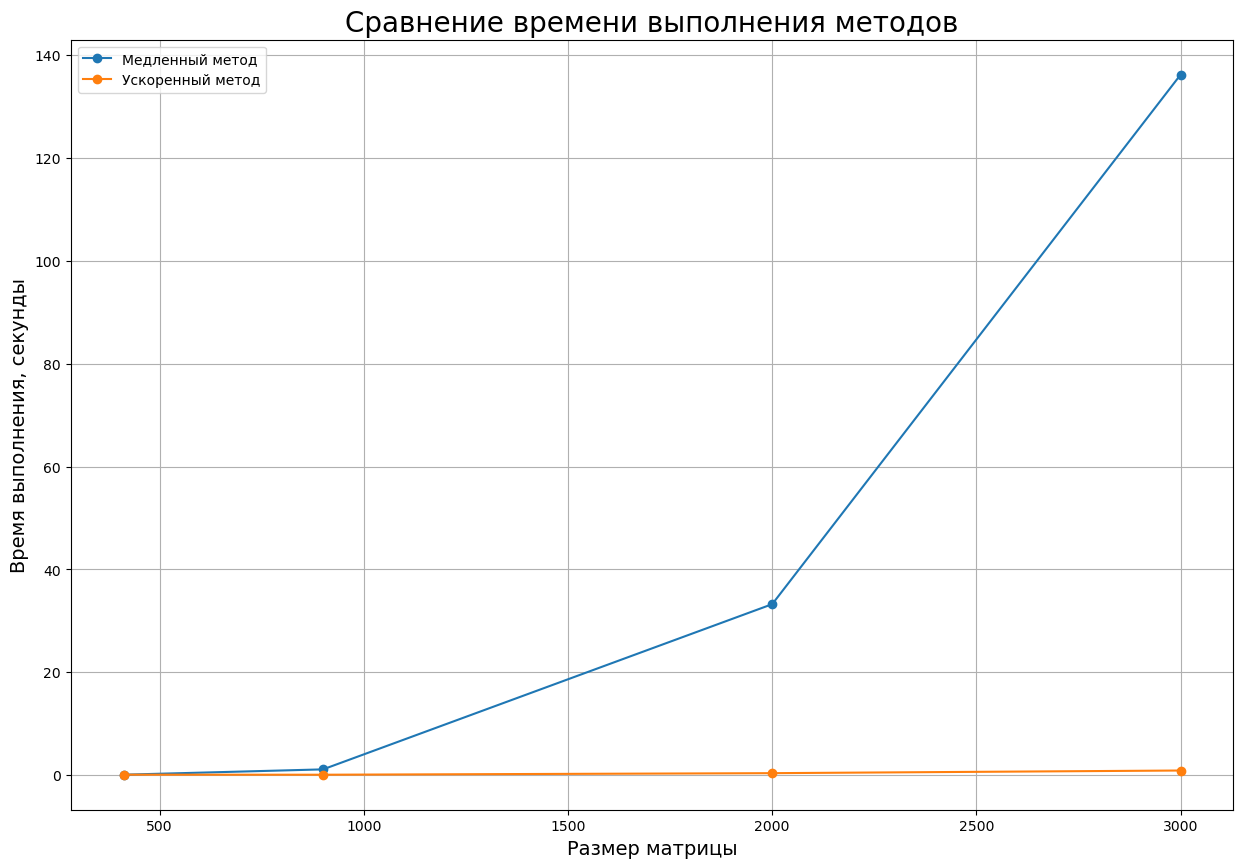

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Список, на котором буду формировать размер матрицы MatSize[n]*MatSize
MatSize = [412, 900, 2000, 3000]
results = []
slow_times = []
fast_times = []
    
for ms in MatSize:
    A = np.random.rand(ms, ms)
    B = np.random.rand(ms, ms)

    MatSlow, TimeSlow = Timer_1(A, B)
    MatFast, TimeFast = Timer_2(A, B)
    
    print(f"Размер матрицы =", ms)
    print(f"Время медленного подсчета = {TimeSlow:.6f} с.")
    print(f"Время ускоренного подсчета = {TimeFast:.6f} с.")
    print()

    # Сравнение результатов двух функций, если они "близки", то верно
    if np.allclose(MatSlow, MatFast):
        print()
        print()
    else:
        print("Ошибка")
        print()
    

    results.append((ms, TimeSlow, TimeFast))
    slow_times.append(TimeSlow)
    fast_times.append(TimeFast)

plt.figure(figsize=(15, 10))
plt.plot(MatSize, slow_times, marker='o', label='Медленный метод')
plt.plot(MatSize, fast_times, marker='o', label='Ускоренный метод')
plt.title('Сравнение времени выполнения методов', fontsize=20)
plt.xlabel('Размер матрицы', fontsize=14)
plt.ylabel('Время выполнения, секунды', fontsize=14)
plt.legend()
plt.grid()

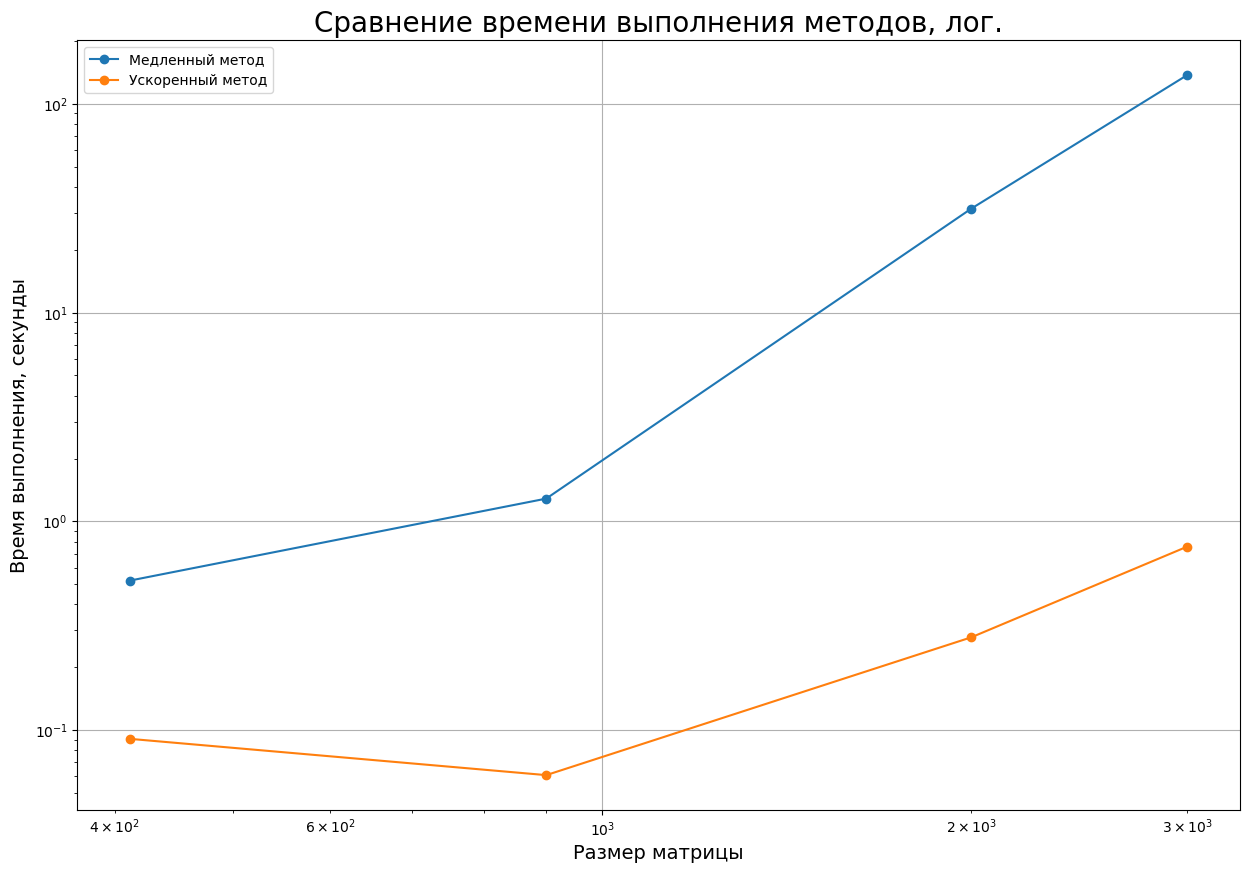

In [11]:
# Так же могу построить лог. график, т.к для ускоренного варианта просчета значения времени (функции), слишком мало

plt.figure(figsize=(15, 10))
plt.plot(MatSize, slow_times, marker='o', label='Медленный метод')
plt.plot(MatSize, fast_times, marker='o', label='Ускоренный метод')
plt.title('Сравнение времени выполнения методов, лог.', fontsize=20)
plt.xlabel('Размер матрицы', fontsize=14)
plt.ylabel('Время выполнения, секунды', fontsize=14)
plt.legend()
plt.grid()

plt.xscale('log')
plt.yscale('log')
plt.show()